In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path_1 = "/content/drive/My Drive/IMDDataSample1deg_1981_2021.npy"
file_path_2 = "/content/drive/My Drive/BiasDataSample1deg_1981_2021.npy"
data_1 = np.load(file_path_1)
data_2 = np.load(file_path_2)

In [6]:
data_1.shape

(2132, 36, 36)

In [7]:
data_2.shape

(2132, 36, 36)

In [8]:
data_1

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [9]:
data_2

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [10]:
data_1_1981_2013 = data_1[:1716, :, :]
data_2_1981_2013=data_2[:1716,:,:]

In [11]:
differences=data_2_1981_2013-data_1_1981_2013

In [12]:
mean_differences=np.mean(differences,axis=(1,2))
global_mean_difference=np.mean(differences)
print(global_mean_difference)

-0.646384


In [13]:
time_steps = np.arange(1716)

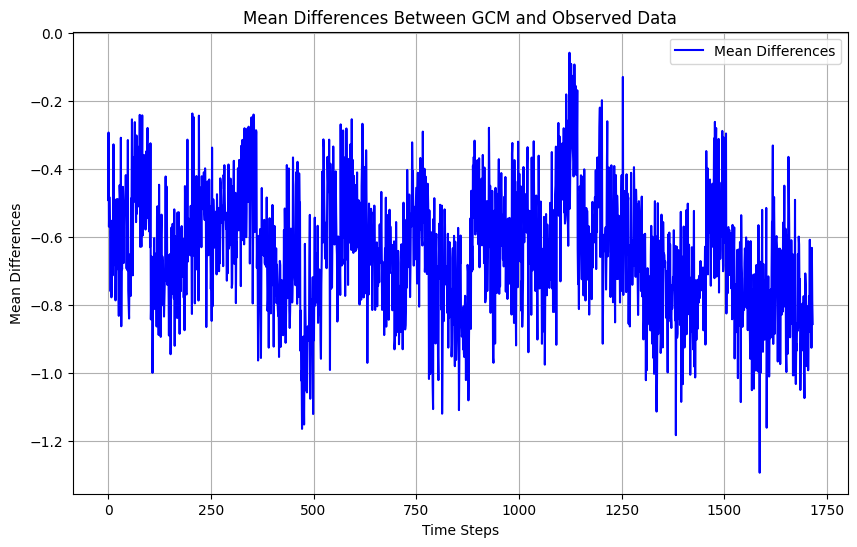

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(time_steps, mean_differences, color='blue', label='Mean Differences')
plt.xlabel('Time Steps')
plt.ylabel('Mean Differences')
plt.title('Mean Differences Between GCM and Observed Data')
plt.legend()
plt.grid()
plt.show()

In [15]:
def edsr(scale_factor, num_res_blocks=8):
    input_img = Input(shape=(36, 36, 1))

    # Initial convolution
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)

    # Residual blocks
    for _ in range(num_res_blocks):
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Scaling layer
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Add()([input_img, x])

    # Upsampling
    for _ in range(scale_factor // 2):
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Final convolution
    output_img = Conv2D(1, (3, 3), activation='linear', padding='same')(x)

    model = Model(input_img, output_img)
    return model

In [16]:
precip_data = data_2_1981_2013[..., np.newaxis]  
precip_data = precip_data / np.max(precip_data)

In [17]:
precip_data.shape

(1716, 36, 36, 1)

In [18]:
train_size = int(0.8 * precip_data.shape[0])
train_data = precip_data[:train_size]
val_data = precip_data[train_size:]

In [19]:
scale_factor = 2
edsr_model = edsr(scale_factor)
edsr_model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
batch_size = 16
epochs = 2
edsr_model.fit(train_data, train_data, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_data))

Epoch 1/2
86/86 [==============================] - 175s 2s/step - loss: 1.3301e-06 - val_loss: 1.1835e-06
Epoch 2/2
86/86 [==============================] - 175s 2s/step - loss: 1.1785e-06 - val_loss: 1.0525e-06


In [31]:
corrected_precip_data = edsr_model.predict(precip_data)

54/54 [==============================] - 50s 928ms/step


In [32]:
corrected_precip_data = corrected_precip_data.squeeze()

In [33]:
corrected_precip_data = corrected_precip_data * np.max(precip_data)

In [34]:
corrected_differences=data_2_1981_2013-corrected_precip_data

In [35]:
mean_corrected_differences=np.mean(corrected_differences,axis=(1,2))
global_mean_corrected_difference=np.mean(corrected_differences)
print(global_mean_corrected_difference)

0.9998934


In [36]:
time_steps = np.arange(1716)

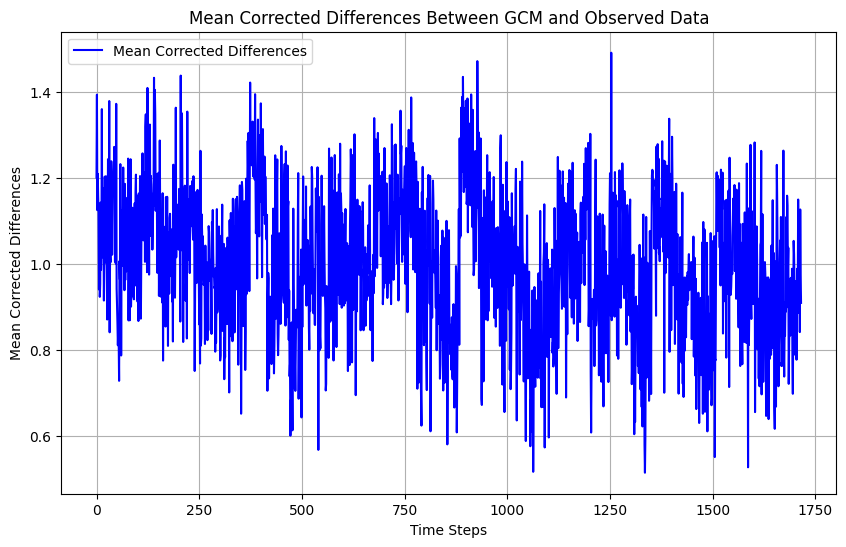

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(time_steps, mean_corrected_differences, color='blue', label='Mean Corrected Differences')
plt.xlabel('Time Steps')
plt.ylabel('Mean Corrected Differences')
plt.title('Mean Corrected Differences Between GCM and Observed Data')
plt.legend()
plt.grid()
plt.show()